In [1]:
import numpy as np 
import pandas as pd
import regex as re
import unicodedata as ud
import nltk
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import wordpunct_tokenize
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
import multiprocessing
from tqdm import tqdm
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import numpy as np

## Movies Datasets

In [347]:
forties_df = pd.read_csv('1940s_data/1940s_movies.csv')
fifties_df = pd.read_csv('1950s_data/1950s_movies.csv')
sixties_df = pd.read_csv('1960s_data/1960s_movies.csv')
seventies_df = pd.read_csv('1970s_data/1970s_movies.csv')

#### EDA functions

In [48]:
def describe_dataframe(df):
    
    for column in df.columns:
        
        print('Column Name: ', u'\u202B' + str(column) + u'\u202C')
        print(df[column].describe())
        print('\n'+'-'*20)

#### Cleansing functions

In [4]:
def change_empty_entries_to_None(df):
    for column in df.columns:
        for row_index in range(df.shape[0]):
            if '??' in str(df.loc[row_index, column]) or \
            df.loc[row_index, column] == 'nan' or \
            df.loc[row_index, column] == '-' or \
            type(df.loc[row_index, column]) == float:
                    df.loc[row_index, column] = None
    return df
    

In [242]:
def check_for_non_numeric_types(df, column):
    
    for row_index in range(df.shape[0]):
        cell_value = df.loc[row_index, column]
        if(cell_value.isalpha()):
            print(cell_value)
#             df[row_index, column] = float(0)
#     return df

In [6]:
def get_indices_to_drop(df, column_name):
    indices = []
    for row_index in range(df.shape[0]):
        cell_content = df.loc[row_index,column_name]
        if(type(cell_content)== float):
            indices.append(row_index)
    return indices

In [56]:
def unify_date_format(df):
    for row in range(df.shape[0]):
        
        release_day = df.iloc[row, 15]
        if len(str(release_day)) == 4:
            df.iloc[row,17] = release_day
            df.iloc[row,16] = 'يناير'

    return df

In [57]:
def expand_release_date(df):
    # line continuation operators  '\' used for cleaner code
    df[['اليوم', 'الشهر', 'السنة']] = \
    df['تاريخ العرض'].str.split(' ', expand = True)
    
    return df
    

In [9]:
def find_movies_with_missing_synopses(df):
    
    missing_movies = []
    for row_index in range(df.shape[0]):
        if(type(df.iloc[row_index, 3]) == float):
            missing_movies.append(df.iloc[row_index, 0])
            
    return missing_movies

In [10]:
def parse_line(line_to_parse):
    
            parsed_values = line_to_parse.split('||')
            movie_name_date = parsed_values[0].strip(')').split('(')
            
            name = movie_name_date[0]
            year = movie_name_date[1]
            df_feature = parsed_values[1]
            
            return name, year, df_feature

In [453]:
def add_scraped_features(df, file_path, column_name):
    
    with open(file_path, 'r') as filehandle:
        
        for line in filehandle:
            
            current_line = line[:-1]
            name, year, df_feature = parse_line(current_line)
            if(not(df_feature == '') \
              or (str(df_feature) == 'nan')):
                df.loc[(df['اسم الفيلم'] == name) \
                     & (df['السنة'] == year), column_name] = df_feature     
    return df

In [12]:
def filter_foregin_movies(df, file_path):
    
    with open(file_path, 'r') as filehandle:
            
        for line in filehandle:
            
            current_line = line[:-1]
            name, year, country = parse_line(current_line)
           
            if(not(('مصر') in country)):   
                movie_index = df.loc[(df['اسم الفيلم'] == name) \
                                     & (df['السنة'] == year)].index
                df.drop(inplace = True, index = movie_index)
    return df

In [13]:
def get_avg_short_movie_time(df):
    
    short_movies_durations = df[' مدة الفيلم (دقيقة)'].loc[ \
                                    df[' تصنيف الفيلم'] == 'ﻗﺼﻴﺮ']
    avg_duration = np.average(list(short_movies_durations))
    
    return avg_duration

In [175]:
def get_null_percentage(df):
    
    total_count = df.shape[0]
    for column in df.columns:
    
        missing_count = df[column].isna().sum()
        missing_percentage = (missing_count/total_count)*100
        print('>> ' + u'\u202B' + column + ': '+ str(round(missing_percentage)) + '%')

## *_1940s Movies_*

### EDA

In [15]:
describe_dataframe(forties_df)

Column Name:  ‫اسم الفيلم‬
count             331
unique            330
top       خاتم سليمان
freq                2
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫ تاريخ العرض‬
count      331
unique     216
top       1946
freq        24
Name:  تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       127
unique        9
top       ??ا??
freq         46
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count    331.000000
mean     106.399698
std       11.097976
min       70.000000
25%      100.000000
50%      105.000000
75%      110.000000
max      152.000000
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count                                                   316
unique                                                  316
top       شابان يعملان كيماويين في معمل، يتنافسان على حب...
freq                                                      1
Name: ملخص, dtype: object

--------------------
Column

In [60]:
forties_df.loc[forties_df['اسم الفيلم'] == 'خاتم سليمان']

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
174,خاتم سليمان,1946,NaN,103.2,NaN,أبو بثينة,أمينة شريف,أفلام حرب,NaN,NaN,NaN,NaN,NaN,فؤاد شبل,NaN
227,خاتم سليمان,1947,ا????ا??,117.0,تناول الفيلم في إطار من الخيال، قصة المعلم بيو...,"حسن رمزي,السيد زيادة","ليلى مراد,يحيى شاهين,زكي رستم,نيللي مظلوم,ثريا...",أفلام النصر (محمد حسن رمزي وشركاه),"مصطفى حسن,وحيد فريد","ألبير نجيب,وفيقة أبو جبل",حبيب خوري,قاسم وجدي,"حسين السيد,السيد زيادة,رياض السنباطي,محمد القص...","حسن رمزي,ألبير نجيب,عبدالرحمن شريف",NaN


In [61]:
forties_df.dtypes

اسم الفيلم      object
تاريخ العرض     object
التصنيف         object
المدة          float64
ملخص            object
تأليف           object
تمثيل           object
إنتاج           object
تصوير           object
مونتاج          object
ديكور           object
ملابس           object
موسيقى          object
إخراج           object
توزيع           object
dtype: object

In [348]:
forties_df['التصنيف'].value_counts()

??ا??       46
???????     26
??????      25
ا????ا??    16
?????        7
????         2
تاريخي       2
?????ا?      2
???          1
Name: التصنيف, dtype: int64

In [349]:
get_null_percentage(forties_df)

>> ‫اسم الفيلم: 0%
>> ‫تاريخ العرض: 0%
>> ‫التصنيف: 62%
>> ‫المدة: 0%
>> ‫ملخص: 5%
>> ‫تأليف: 7%
>> ‫تمثيل: 1%
>> ‫إنتاج: 26%
>> ‫تصوير: 15%
>> ‫مونتاج: 28%
>> ‫ديكور: 39%
>> ‫ملابس: 94%
>> ‫موسيقى: 35%
>> ‫إخراج: 6%
>> ‫توزيع: 49%


### Cleansing

In [350]:
forties_df = change_empty_entries_to_None(forties_df)

In [351]:
forties_df['التصنيف'].value_counts()

تاريخي    2
Name: التصنيف, dtype: int64

In [352]:
# forties_df = check_for_non_numeric_types(forties_df, 'المدة')

In [353]:
expanded_date_40s = forties_df.copy(deep = True)

In [354]:
expanded_date_40s = expand_release_date(forties_df)
expanded_date_40s = unify_date_format(expanded_date_40s)

In [357]:
expanded_date_40s = expanded_date_40s.drop(columns=['تاريخ العرض','اليوم'])
expanded_date_40s['التقييم'] = None

In [358]:
foreigns_filtered_40s  = expanded_date_40s.copy(deep = True)

In [454]:
foreigns_filtered_40s = filter_foregin_movies(expanded_date_40s \
                                                , '1940s_data/countries_1940s.txt')

In [455]:
genre_added_40s = foreigns_filtered_40s.copy(deep = True)

In [456]:
genre_added_40s = add_scraped_features(foreigns_filtered_40s \
                                          , '1940s_data/1940s_genres.txt' \
                                         , 'التصنيف')

In [457]:
genre_added_40s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                75
ﻛﻮﻣﻴﺪﻱ               23
موسيقي / استعراضي    13
ﺭﻭﻣﺎﻧﺴﻲ              12
ﻋﺎﺋﻠﻲ                 2
ﺟﺮﻳﻤﺔ                 2
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          2
ﺣﺮﺏ                   1
ﺧﻴﺎﻝ                  1
ﻣﻐﺎﻣﺮاﺕ               1
Name: التصنيف, dtype: int64

In [458]:
ratings_added_40s = genre_added_40s.copy(deep = True)

In [459]:
ratings_added_40s = add_scraped_features(genre_added_40s \
                                          , '1940s_data/1940s_ratings.txt' \
                                         , 'التقييم')

In [460]:
synopsis_added_40s = ratings_added_40s.copy(deep = True)

In [461]:
synopsis_added_40s = add_scraped_features(ratings_added_40s \
                                          , '1940s_data/1940s_synopses.txt' \
                                         , 'ملخص')

In [462]:
synopsis_added_40s = synopsis_added_40s.reset_index(drop=True)

In [463]:
synopsis_added_40s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
86,الآنسه بوسه,ﺩﺭاﻣﺎ,115.0,يتفق فوزي باشا مع ابنته أن من يتزوجها لا بد وأ...,"أبو السعود الإبياري,نيازي مصطفى","نور الهدى,محمود ذو الفقار,بشارة واكيم,فردوس مح...","إميل يزبك,نحّاس فيلم","مصطفى حسن,وحيد فريد",ألبير نجيب,"روبرت شارفنبرج,جعفر والى,ستوديو لاما",None,"زكريا أحمد,رياض السنباطي,محمود الشريف,بيرم الت...","نيازي مصطفى,حسن الإمام",نحّاس فيلم,مارس,1945,5.3


In [464]:
get_null_percentage(synopsis_added_40s)

>> ‫اسم الفيلم: 0%
>> ‫التصنيف: 60%
>> ‫المدة: 0%
>> ‫ملخص: 2%
>> ‫تأليف: 7%
>> ‫تمثيل: 1%
>> ‫إنتاج: 26%
>> ‫تصوير: 14%
>> ‫مونتاج: 28%
>> ‫ديكور: 39%
>> ‫ملابس: 94%
>> ‫موسيقى: 35%
>> ‫إخراج: 6%
>> ‫توزيع: 48%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التقييم: 5%


In [465]:
synopsis_added_40s['التقييم'] = synopsis_added_40s['التقييم'].astype(float)

## *_1950s Movies_*

In [466]:
fifties_df.sample(10)

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
230,بنات حواء,ﻛﻮﻣﻴﺪﻱ,115.0,(عصمت) صاحبة محلات الصبا والجمال للأزياء مضربة...,"نيازي مصطفى,أبو السعود الإبياري","محمد فوزي,مديحة يسري,شادية,إسماعيل يس,زينات صد...","أفلام محمد فوزي,روفائيل جبور,رشاد فريد,محمد فوزي","وحيد فريد,حسن داهش,عبدالله ياقوت","اميل بحرى,نعمت فايد,حسين أحمد","أنطوان بوليزويس,نجيب خوري",محلات شملا,"محمد فوزي,صالح جودت,أبو السعود الإبياري,عبدالع...","نيازي مصطفى,محمد جلال",None,مارس,1954,7.7
291,نحن بشر,ﺩﺭاﻣﺎ,110.0,يبحث ربيع عن عمل بعد خروجه من الاصلاحية، ويلتق...,"كامل عبدالسلام,إبراهيم الورداني,محمد مصطفى سامي","هدى سلطان,محمود المليجي,درية أحمد,علوية جميل,ح...","أفلام النجم الفضي,سليمان البارودي,عدلي خليل","امبرتو لانزانو,مسعود عيسى,فارس وهبة",اميل بحرى,عباس حلمي,None,"فتحي قورة,مصطفى عبدالرحمن,محمد عبدالوهاب,أحمد ...","إبراهيم عمارة,محمد عمارة",None,يناير,1955,5.7
210,حكم الزمان,None,96.0,تنتهي رحلة المهندس عادل من أوربا ويعود للقاهرة...,يوسف عيسى,"نور الهدى,عماد حمدي,ماجدة,سميحة توفيق,زوزو شكي...",None,جوليو دى لوكا,"مصطفى قاسم,فتحى قاسم",هاجوب اصلانيان,None,"عبدالفتاح مصطفى,جليل البنداري,أحمد صدقي",هنري بركات,None,يناير,1953,6.8
94,ورد الغرام,ﺭﻭﻣﺎﻧﺴﻲ,120.0,يطلب لطيف ابن عبدالغني أن يتزوج من إلهام ابنة ...,"هنري بركات,بديع خيري,يوسف عيسى","محمد فوزي,ليلى مراد,سليمان نجيب,سراج منير,نور ...","محمد فوزي,أفلام محمد فوزي,روفائيل جبور","عواد أبو النجا,عبدالله ياقوت,وحيد فريد","سعيد الشيخ,حسين أحمد","أنطوان بوليزويس,نجيب خوري",None,"محمد فوزي,بديع خيري,فتحي قورة,عبدالفتاح مصطفى,...","هنري بركات,ريمون نصور,طلعت علام",منتخبات بهنا فيلم,ديسمبر,1951,6.1
211,اللص الشريف,ﻛﻮﻣﻴﺪﻱ,91.0,إسماعيل عجلاتي يرغب في الزواج من فتحية، وهى وت...,علي الزرقاني,"إسماعيل يس,شادية,لولا صدقي,محمود السباع,محمد ت...","حلمي حليم,حمادة عبدالوهاب","حسن البحيري,روبير طمبا,عواد محمد","اميل بحرى,فكري رستم,ليلى مغربى,زينب عويس","أنطوان بوليزويس,ستوديو مصر,عثمان حسين,نجيب خوري",None,"إسماعيل يس,فتحي قورة,بيبى المانزا,ابن الليل,عز...","حمادة عبدالوهاب,محمود فريد,شريف حمودة",None,يناير,1953,6.3
253,أسعد الأيام,ﺩﺭاﻣﺎ,89.0,مرسي موظف حكومي ويعمل في إحدى الشركات، تقرر ال...,"إبراهيم الورداني,حسن رضا","يوسف وهبي,زهرة العلا,شكري سرحان,برلنتي عبدالحم...",أطلس فيلم,كليليو (ك. ستشفللي),"فتحى قاسم,نعمت فايد","روبرت شارفنبرج,عبدالمنعم شكري",None,إبراهيم حجايج,"حسن رضا,حسين تعاريت,فوزي علي,محمد جلال",None,يوليو,1954,6.1
186,حب في الظلام,ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ,114.0,تعيش نعمت مع والدها وشقيقتها، بينما يعيش جارهم...,"السيد بدير,يوسف عيسى,محمد الإمام","فاتن حمامة,عماد حمدي,فريد شوقي,أمينة رزق,عبدال...","حسن الإمام,أفلام حسن الإمام الجديدة,رمسيس نجيب...","مصطفى حسن,ستوديو نحاس (النيل),حلمى فريد","ألبير نجيب,ميشيل الياس,عطية عبده,انجا وميلا","ولي الدين سامح,عبدالحميدالسخاوي",None,"أحمد صدقي,علي فراج,أحمد صبرة,يوسف صالح,إبراهيم...","حسن الإمام,عبدالرحمن شريف",دولار فيلم (إسماعيل الكردي وأولاده),يونيو,1953,6.2
130,عايزة أتجوز,ﺭﻭﻣﺎﻧﺴﻲ,122.0,تدور أحداث الفيلم حول المطربة (نور) وحيرتها ال...,"أبو السعود الإبياري,أحمد بدرخان","نور الهدى,فريد الأطرش,سليمان نجيب,عبدالسلام ال...",أفلام فريد الأطرش,عبدالحليم نصر,كمال الشيخ,None,None,فريد الأطرش,"أحمد بدرخان,عاطف سالم",None,اغسطس,1952,6.4
12,الهام,None,85.0,محرم بك(يحيى شاهين)يعيش فوق الجبل، قريبا من...,"عبداللطيف واكد,محمد فتحي صالح عزب,محمود رشاد,م...","ماري كويني,يحيى شاهين,جلال حرب,سليمان نجيب,محم...","ماري كويني,عبدالحميد زكي,افلام النداء","محمد عبدالعظيم,عبدالله ياقوت,روبير طمبا","فيوليت مغربى,فتحى قاسم,زينب عويس","ستوديو مصر,عز الدين الترجمان,عثمان حسين,أنطوان...",None,"عصمت عبدالعليم,محمد صالح,عبدالحليم نويرة,جلال ...","بهاء الدين شرف,محمود رشاد,حسن الصيفي,محمد جلال",ستوديو مصر,ابريل,1950,None
317,في سبيل الحب,ﺩﺭاﻣﺎ,90.0,تنمو قصة حب بين فاطمة وحسن في أحضان الطبيعة، و...,"عثمان أباظة,محمد الإمام,عيسى كرامة","ماجدة,يحيى شاهين,عبدالعزيز خليل,عبدالعليم خطاب...","إميل يزبك,ستوديو جيزة","يوسف كرامة,البير رياض,حسن خليل","عباس عثمان,كمال فهمي,نجيب عرفه",حلمي عزب,أحمد الكسار,"طاهر أبو فاشا,إبراهيم حسين,فؤاد الظاهري","عيسى كرامة,إبراهيم السيد, سعيد حسن",منتخبات بهنا فيلم,اكتوبر,1955,5.3


In [467]:
describe_dataframe(fifties_df)

Column Name:  ‫اسم الفيلم‬
count              530
unique             529
top       هل أقتل زوجى
freq                 2
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       377
unique       15
top       ﺩﺭاﻣﺎ
freq        192
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count    530.000000
mean     108.201698
std       13.180526
min       53.000000
25%      100.000000
50%      108.350000
75%      115.000000
max      170.000000
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count                                                   526
unique                                                  526
top       تختلف سلوى (ماجدة) كثيرًا عن أختها ليلى (آمال ...
freq                                                      1
Name: ملخص, dtype: object

--------------------
Column Name:  ‫تأليف‬
count                     512
unique                    339
top       أبو السعود الإبياري
freq                       27
Name:

In [468]:
fifties_df['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                192
ﻛﻮﻣﻴﺪﻱ                60
ﺭﻭﻣﺎﻧﺴﻲ               44
موسيقي / استعراضي     31
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          14
تاريخي                 9
ﺟﺮﻳﻤﺔ                  8
ﺣﺮﻛﺔ                   6
ﺧﻴﺎﻝ ﻋﻠﻤﻲ              3
ﻋﺎﺋﻠﻲ                  3
ﺣﺮﺏ                    2
ﻏﻤﻮﺽ                   2
ﺧﻴﺎﻝ                   1
ﻣﻐﺎﻣﺮاﺕ                1
ﺭﻋﺐ                    1
Name: التصنيف, dtype: int64

In [469]:
fifties_df[fifties_df.duplicated(subset = ['اسم الفيلم'])]

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
441,هل أقتل زوجى,ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ,87.0,يخرج الزوج إلى عمله وينتهز رجل غامض هذه الفرصة...,محمد كامل حسن المحامي,"محسن سرحان,سميرة أحمد,توفيق الدقن,سهير البابلي...","وليم رزق,حسن موافى,فرغل البارودي,حسام الدين مصطفى","البير رياض,كليليو (ك. ستشفللي)",حسن حلمي (حسنوف),"أنطوان بوليزويس,عبدالمنعم على",None,None,"حسام الدين مصطفى,سيمون صالح,مصطفى سمهان,إبراهي...",None,مايو,1958,5.4


In [470]:
fifties_df.loc[fifties_df['اسم الفيلم'] == 'هل أقتل زوجى']

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
378,هل أقتل زوجى,None,108.1,,None,None,None,None,None,None,None,None,None,None,يناير,1956,0
441,هل أقتل زوجى,ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ,87.0,يخرج الزوج إلى عمله وينتهز رجل غامض هذه الفرصة...,محمد كامل حسن المحامي,"محسن سرحان,سميرة أحمد,توفيق الدقن,سهير البابلي...","وليم رزق,حسن موافى,فرغل البارودي,حسام الدين مصطفى","البير رياض,كليليو (ك. ستشفللي)",حسن حلمي (حسنوف),"أنطوان بوليزويس,عبدالمنعم على",None,None,"حسام الدين مصطفى,سيمون صالح,مصطفى سمهان,إبراهي...",None,مايو,1958,5.4


In [377]:
expanded_date_50s = fifties_df.copy(deep = True)

In [378]:
expanded_date_50s = expand_release_date(fifties_df)
expanded_date_50s = unify_date_format(expanded_date_50s)

In [379]:
expanded_date_50s.drop(columns=['تاريخ العرض','اليوم'], inplace = True)
expanded_date_50s['التقييم'] = None

In [472]:
foreign_filtered_50s = expanded_date_50s.copy(deep = True)

In [473]:
foreign_filtered_50s = filter_foregin_movies(expanded_date_50s
                                               , '1950s_data/countries_1950s.txt')

In [474]:
ratings_added_50s = foreign_filtered_50s.copy(deep = True)

In [475]:
ratings_added_50s = add_scraped_features(foreign_filtered_50s \
                                           , '1950s_data/1950s_ratings.txt'
                                           , 'التقييم')

In [476]:
genres_added_50s = ratings_added_50s.copy(deep = True)

In [477]:
genres_added_50s = add_scraped_features(ratings_added_50s \
                                           , '1950s_data/1950s_genres.txt'
                                           , 'التصنيف')

In [478]:
synopsis_added_50s = genres_added_50s.copy(deep = True)

In [479]:
synopsis_added_50s = add_scraped_features(genres_added_50s \
                                          , '1950s_data/1950s_synopses.txt' \
                                         , 'ملخص')

In [480]:
synopsis_added_50s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                192
ﻛﻮﻣﻴﺪﻱ                60
ﺭﻭﻣﺎﻧﺴﻲ               44
موسيقي / استعراضي     31
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          14
تاريخي                 9
ﺟﺮﻳﻤﺔ                  8
ﺣﺮﻛﺔ                   6
ﺧﻴﺎﻝ ﻋﻠﻤﻲ              3
ﻋﺎﺋﻠﻲ                  3
ﺣﺮﺏ                    2
ﻏﻤﻮﺽ                   2
ﺧﻴﺎﻝ                   1
ﻣﻐﺎﻣﺮاﺕ                1
ﺭﻋﺐ                    1
Name: التصنيف, dtype: int64

In [481]:
synopsis_added_50s = synopsis_added_50s.reset_index(drop=True)

In [482]:
synopsis_added_50s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
264,جعلوني مجرما,ﺩﺭاﻣﺎ,105.0,ظن الطفل سلطان عقب وفاة والده أن عمه سيرعاه، و...,"رمسيس نجيب,فريد شوقي,السيد بدير,عاطف سالم,نجيب...","فريد شوقي,هدى سلطان,عبدالمنعم إسماعيل,يحيى شاه...","رمسيس نجيب,أديب جابر,خليل دياب,حسن موافى","وحيد فريد,حلمى فريد","عطية عبده,ميشيل الياس","ولي الدين سامح,عبدالحميد السخاوي",None,"رياض السنباطي,محمد فوزي,أحمد صدقي,محمد علي أحم...","عاطف سالم,سعد عرفة",None,اكتوبر,1954,8.4


In [483]:
get_null_percentage(synopsis_added_50s)

>> ‫اسم الفيلم: 0%
>> ‫التصنيف: 29%
>> ‫المدة: 0%
>> ‫ملخص: 1%
>> ‫تأليف: 3%
>> ‫تمثيل: 0%
>> ‫إنتاج: 12%
>> ‫تصوير: 9%
>> ‫مونتاج: 13%
>> ‫ديكور: 14%
>> ‫ملابس: 84%
>> ‫موسيقى: 30%
>> ‫إخراج: 1%
>> ‫توزيع: 54%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التقييم: 6%


In [484]:
synopsis_added_50s['التقييم'] = synopsis_added_50s['التقييم'].astype(float)

## *_1960s Movies_*

In [485]:
sixties_df.sample(10)

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
520,كيف تسرق مليونير,ﻛﻮﻣﻴﺪﻱ,110.0,يعمل الشباب الثلاثة محفوظ وعاشور ومنصور في مطع...,فاروق صبري,"محمد عوض,عبدالمنعم إبراهيم,محمد رضا,عادل إمام,...","مؤسسة السينما, فتحي حسن,محمد حجاج,زكريا إبراه...","عادل عبدالعظيم,محمد عبدالعظيم,عبدالحميد عمر","محيي الدين عبدالجواد,وداد راغب,صلاح عبدالرازق","حسين الشريف (حسين شريف),ماهر عبدالنور",عزيزه مراد,فؤاد الظاهري,"محمد يوسف,نجدي حافظ,جمال عمار",None,فبراير,1968,5.3
53,قيس وليلى,None,110.0,يروي الفيلم قصة قيس بن الملوح وليلى التي يهيم ...,"حسن توفيق,أحمد ضياء الدين,ولي الدين سامح","ماجدة,شكري سرحان,محمود السباع,عمر الحريري,سعيد...","أفلام جبرائيل تلحمي,كوندور فيلم,جبرائيل تلحمي,...","وديد سري,كمال كريم,جوليو دى لوكا","بدر لاما,ألبير نجيب,اميل بحرى","محروس زيادة,ولي الدين سامح",None,"زكريا أحمد,يوسف صالح,فريد غصن,فؤاد الظاهري","أحمد ضياء الدين,جمال الدماطي,عدلي خليل,إبراهيم...","منتخبات بهنا فيلم,أفلام جبرائيل تلحمي",يناير,1960,7.2
71,الخرساء,ﺟﺮﻳﻤﺔ,120.0,نعيمة الفتاة الخرساء تُتوفى والدتها وهي صغيرة ...,محمد مصطفى سامي,"هالة فاخر,سميرة أحمد,فاخر فاخر,زوزو نبيل,عبدال...","أفلام العالم العربى,أديب جابر,عادل فريد","وحيد فريد,مسعود عيسى,عبدالله ياقوت","رشيدة عبدالسلام,فتحي داود,انجا وميلا","أنطوان بوليزويس,نجيب خوري,عثمان حسين,كوستا وبهيج",أحمد الكسار,"علي إسماعيل,حسيب غباشي","حسن الإمام,صالح فوزي,عبدالرحمن الشريف",الشرق للتوزيع,يناير,1961,5.4
420,آخر العنقود,ﺩﺭاﻣﺎ,90.0,محمد وسعد صديقان منذ الطفولة، إلا أن سعد يتسم ...,زهير بكير,"تحية كاريوكا,مها صبري,صلاح قابيل,شمس البارودي,...",أمية فيام,على حسن,"عبدالعزيز فخري,سلوى مرشيان,صلاح خليل","عجمي عبدالرحمن,حلمي عزب",أحمد الكسار,None,"زهير بكير,محمد عمارة,زكي صالح",None,ابريل,1966,5.9
116,ست البنات,ﻛﻮﻣﻴﺪﻱ,90.0,تسعى منيرة (هند رستم) لتحقيق أحلامها مع زوجٍ ي...,أمين يوسف غراب,"هند رستم,رشدي أباظة,عبدالمنعم إبراهيم,عدلي كاس...","حسام الدين مصطفى,حسن موافى","مصطفى حسن,عبدالمنعم بهنسي","حسين عفيفي,وديع شفيق,ناهد مكاوي,نادية شكري,فار...","عباس حلمي,عبدالحميد السخاوي,عبد المنعم علي,ستو...",None,"يوسف شوقي,عطية شرارة","حسام الدين مصطفى,طلعت علام",دينار فيلم,يناير,1961,6.3
148,أنا الهارب,None,104.0,تدور أحداث هذا الفيلم حول حمدي (فريد شوقي) الذ...,"نيازي مصطفى,عبدالفتاح مصطفى,بهجت قمر,أحمد شوقي...","محمد رضا,أنور ماضي,أحمد لوكسر,فايز حجاب,كمال ا...",None,مسعود عيسى,"جلال مصطفى,عبدالعزيز فخري",عباس حلمي,None,None,"نيازي مصطفى,أحمد السبعاوي",None,يناير,1962,5.8
80,وحيدة,None,85.0,وحيدة مدرسة بالإسكندرية، مصابة بضعف في السمع و...,محمد كامل حسن المحامي,"السيد بدير,عبدالمنعم إسماعيل,سميرة محمد,مريم ف...","كوندور فيلم,ستوديو لاما,سامي شلبي,افلام الإتحا...",فيرى فاركاش (فرانسوا فاركاش),فكري رستم,"ستوديو الأهرام (ستوديوهات الأهرام),عباس حلمي",None,"رياض السنباطي,فريد غصن,إبراهيم حسن,محمد كامل ح...",None,كوندور فيلم,سبتمبر,1961,5.8
189,انسى الدنيا,None,80.0,شاب فقير يحب فتاة وينافسه في حبها فكهاني الحي ...,None,"رياض القصبجي,لولا عبده,عبدالغني النجدي,ماري من...",None,None,None,None,None,None,إلهامي حسن,None,يناير,1962,6.8
309,آخر شقاوة,ﺩﺭاﻣﺎ,105.0,تدور قصة العمل حول ثلاث شباب (أنور) و(محسن) و(...,أنور عبدالملك,"أحمد رمزي,حسن يوسف,محمد عوض,زيزي البدراوي,إستي...","يوسف نخلة,يوسف كرامة","مصطفى حسن,البير رياض","عبدالعزيز فخري,سلوى","حلمي عزب,عجمي عبدالرحمن",None,ميشيل يوسف,"عيسى كرامة,مصطفى جمال الدين",أفلام إدوار خياط (ا. خيّاط),نوفمبر,1964,5.8
201,الحقيقة العارية,ﺩﺭاﻣﺎ,115.0,آمال مرشدة سياحية، لكنها مضربة عن الزواج بسبب ...,"محمد عثمان,وجيه نجيب,إبراهيم الورداني","ماجدة,إيهاب نافع,سهام فتحي,فاتن الشوباشي,عبدال...",ماجدة,"عبدالعزيز فهمي,عبدالمنعم بهنسي",ألبير نجيب,None,None,علي إسماعيل,عاطف سالم,None,ديسمبر,1963,5.9


In [394]:
describe_dataframe(sixties_df)

Column Name:  ‫اسم الفيلم‬
count         651
unique        646
top       المتمرد
freq            4
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫تاريخ العرض‬
count      651
unique     324
top       1968
freq        42
Name: تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       359
unique       15
top       ﺩﺭاﻣﺎ
freq        115
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count    651.000000
mean     102.518280
std       13.958636
min       30.000000
25%       95.000000
50%      101.000000
75%      105.400000
max      195.000000
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count                                                   560
unique                                                  557
top       عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...
freq                                                      4
Name: ملخص, dtype: object

--------------------
Column Name:  ‫تأليف‬
co

In [395]:
sixties_df.loc[sixties_df['اسم الفيلم'] == 'شايف خير']

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
606,شايف خير,20 يناير 1969,NaN,90.0,NaN,"طه سالم,محمد شكري جميل,جميل حمودى","محمد النفيس,فاروق فياض,سامى عبدالحميد,فخري ا...",مصلحة السينما والمسرح,"جورج يوسف,عبداللطيف صالح",صبيح عبدالكريم,NaN,NaN,سالم حسين,محمد شكري جميل,NaN
621,شايف خير,1969,NaN,97.7,NaN,NaN,إبراهيم جلال,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [396]:
sixties_df['التصنيف'].value_counts()

ﺩﺭاﻣﺎ           115
ﺭﻭﻣﺎﻧﺴﻲ          87
ﻛﻮﻣﻴﺪﻱ           76
ﺟﺮﻳﻤﺔ            21
اﺳﺘﻌﺮاﺿﻲ         18
ﺣﺮﻛﺔ             11
تاريخي            9
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ      6
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ        5
ﻣﻐﺎﻣﺮاﺕ           3
ﻏﻤﻮﺽ              3
ﺧﻴﺎﻝ ﻋﻠﻤﻲ         2
ﻭﺛﺎﺋﻘﻲ            1
ﻋﺎﺋﻠﻲ             1
ﻗﺼﻴﺮ              1
Name: التصنيف, dtype: int64

In [397]:
sixties_df.dtypes

اسم الفيلم      object
تاريخ العرض     object
التصنيف         object
المدة          float64
ملخص            object
تأليف           object
تمثيل           object
إنتاج           object
تصوير           object
مونتاج          object
ديكور           object
ملابس           object
موسيقى          object
إخراج           object
توزيع           object
dtype: object

In [398]:
sixties_df[sixties_df.duplicated(subset = ['اسم الفيلم', 'تمثيل'])]

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
518,المتمرد,1968,NaN,100.0,عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...,"محمد المرزوقى,عمار الخليفي","سميرة أحمد,طاهر وهب,حطاب الذيب,حسيبة رشدي,الطا...","تونس,عمار الخليفي",عز الدين بن عمار,"فوزية طابع,عمار الخليفي",محمد السهيلى,NaN,NaN,"مصطفى بن إبراهيم,عمار الخليفي",NaN
525,المتمرد,1968,NaN,100.0,عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...,"محمد المرزوقى,عمار الخليفي","سميرة أحمد,طاهر وهب,حطاب الذيب,حسيبة رشدي,الطا...","تونس,عمار الخليفي",عز الدين بن عمار,"فوزية طابع,عمار الخليفي",محمد السهيلى,NaN,NaN,"مصطفى بن إبراهيم,عمار الخليفي",NaN
532,المتمرد,1968,NaN,100.0,عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...,"محمد المرزوقى,عمار الخليفي","سميرة أحمد,طاهر وهب,حطاب الذيب,حسيبة رشدي,الطا...","تونس,عمار الخليفي",عز الدين بن عمار,"فوزية طابع,عمار الخليفي",محمد السهيلى,NaN,NaN,"مصطفى بن إبراهيم,عمار الخليفي",NaN


_**Cleansing**_

In [399]:
sixties_df = change_empty_entries_to_None(sixties_df)

In [400]:
sixties_df.drop_duplicates(subset = ['اسم الفيلم', 'تمثيل']
                          , inplace= True, keep = 'last')

In [401]:
sixties_df.drop(inplace = True, index = \
               sixties_df.loc[sixties_df['التصنيف'] == 'ﻭﺛﺎﺋﻘﻲ'].index)

In [402]:
sixties_df = sixties_df.reset_index(drop = True)

In [403]:
date_expanded_60s = sixties_df.copy(deep = True)

In [404]:
date_expanded_60s = expand_release_date(sixties_df)
date_expanded_60s = unify_date_format(date_expanded_60s)

In [405]:
date_expanded_60s.drop(columns=['تاريخ العرض', 'اليوم'], inplace= True)

In [406]:
# sixties_df.to_csv('1960s_data/1960s_no_duplicates.csv')

In [408]:
date_expanded_60s['التقييم'] = None

In [59]:
# date_expanded_1960s_df.to_csv('1960s_data/date_expanded_1960s.csv')

_**Filling Missing Values**_

* **Add Webscraped Ratings**

In [486]:
foreigns_filtered_60s = date_expanded_60s.copy(deep = True)

In [487]:
foreigns_filtered_60s = filter_foregin_movies(date_expanded_60s \
                                                , '1960s_data/1960s_countries.txt')

In [488]:
ratings_added_60s = foreigns_filtered_60s.copy(deep = True)

In [489]:
ratings_added_60s = add_scraped_features(foreigns_filtered_60s \
                                    , '1960s_data/1960s_ratings.txt' \
                                    , 'التقييم')

In [490]:
genre_added_60s = ratings_added_60s.copy(deep = True)

In [491]:
# ratings_added_60s_df.to_csv('1960s_data/ratings_added_df_60s.csv')

In [492]:
genre_added_60s = add_scraped_features(ratings_added_60s \
                                          , '1960s_data/1960s_genres.txt' \
                                         , 'التصنيف')

In [493]:
# genre_added_60s_df.to_csv('1960s_data/genre_added_60s_df.csv')

In [494]:
genre_added_60s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                171
ﻛﻮﻣﻴﺪﻱ                59
ﺭﻭﻣﺎﻧﺴﻲ               46
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          18
موسيقي / استعراضي     13
ﺟﺮﻳﻤﺔ                 12
ﺣﺮﻛﺔ                   7
ﻋﺎﺋﻠﻲ                  4
ﺧﻴﺎﻝ                   4
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             4
ﻣﻐﺎﻣﺮاﺕ                4
ﺧﻴﺎﻝ ﻋﻠﻤﻲ              2
تاريخي                 2
ﻏﻤﻮﺽ                   1
ﻗﺼﻴﺮ                   1
Name: التصنيف, dtype: int64

In [495]:
synopsis_added_60s = genre_added_60s.copy(deep = True)

In [496]:
synopsis_added_60s = add_scraped_features(genre_added_60s \
                                          , '1960s_data/1960s_synopses.txt' \
                                         , genre_added_60s.columns[3])

In [497]:
synopsis_added_60s = synopsis_added_60s.reset_index(drop=True)

In [498]:
get_null_percentage(synopsis_added_60s)

>> ‫اسم الفيلم: 0%
>> ‫التصنيف: 35%
>> ‫المدة: 0%
>> ‫ملخص: 7%
>> ‫تأليف: 9%
>> ‫تمثيل: 2%
>> ‫إنتاج: 21%
>> ‫تصوير: 15%
>> ‫مونتاج: 23%
>> ‫ديكور: 30%
>> ‫ملابس: 86%
>> ‫موسيقى: 45%
>> ‫إخراج: 6%
>> ‫توزيع: 52%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التقييم: 10%


In [499]:
synopsis_added_60s['التقييم'] = synopsis_added_60s['التقييم'].astype(float)

## *_1970s Movies_*

_**EDA**_

In [423]:
describe_dataframe(seventies_df)

Column Name:  ‫اسم الفيلم‬
count           793
unique          781
top       فرح زهران
freq              4
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫تاريخ العرض‬
count      793
unique     285
top       1972
freq        53
Name: تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       341
unique       18
top       ﺩﺭاﻣﺎ
freq        140
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count     793
unique     89
top       100
freq       93
Name: المدة, dtype: object

--------------------
Column Name:  ‫ملخص‬
count                                                   649
unique                                                  649
top       فيلم وثائقي يستعرض مراحل الجيش المصري (الملقب ...
freq                                                      1
Name: ملخص, dtype: object

--------------------
Column Name:  ‫تأليف‬
count          684
unique         491
top       فيصل ندا
freq            26
Name: تأليف, dtype: obj

In [424]:
seventies_df['ملخص'].isnull().sum()

144

In [425]:
seventies_df['التصنيف'].value_counts()

ﺩﺭاﻣﺎ           140
ﺭﻭﻣﺎﻧﺴﻲ          60
ﻛﻮﻣﻴﺪﻱ           56
ﺟﺮﻳﻤﺔ            22
اﺳﺘﻌﺮاﺿﻲ         15
تاريخي            8
ﺣﺮﻛﺔ              8
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ      5
ﻗﺼﻴﺮ              5
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ        4
ﻣﻐﺎﻣﺮاﺕ           4
ﺣﺮﺏ               3
ﻭﺛﺎﺋﻘﻲ            3
ﻏﻤﻮﺽ              3
ﺭﻳﺎﺿﻲ             2
ﺭﺳﻮﻡ ﻣﺘﺤﺮﻛﺔ       1
ﻋﺎﺋﻠﻲ             1
ﺧﻴﺎﻝ ﻋﻠﻤﻲ         1
Name: التصنيف, dtype: int64

In [426]:
seventies_df[seventies_df.duplicated(subset = ['اسم الفيلم', 'تمثيل'])]

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
154,فرح زهران,1972,NaN,100.5,NaN,محسن زايد,"عبدالعزيز مخيون,إنعام الجريتلي,ممدوح زايد",NaN,NaN,NaN,NaN,NaN,NaN,محسن زايد,NaN
164,فرح زهران,1972,NaN,100.5,NaN,محسن زايد,"عبدالعزيز مخيون,إنعام الجريتلي,ممدوح زايد",NaN,NaN,NaN,NaN,NaN,NaN,محسن زايد,NaN
172,فرح زهران,1972,NaN,100.5,NaN,محسن زايد,"عبدالعزيز مخيون,إنعام الجريتلي,ممدوح زايد",NaN,NaN,NaN,NaN,NaN,NaN,محسن زايد,NaN
306,مخطوبتين بالوراثة,1974,NaN,108.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,الحسناء و قاهر الفضاء,1975,NaN,95,NaN,"محمد جومر,سهيل كنعان","محمود جبر,إغراء,أديب قدورة,نجاح حفيظ,أنور البا...","سميراميس فيلم,دمشق",محمد الرواس,مروان عكاوي,NaN,NaN,هنري,سهيل كنعان,NaN
414,الحسناء و قاهر الفضاء,1975,NaN,95,NaN,"محمد جومر,سهيل كنعان","محمود جبر,إغراء,أديب قدورة,نجاح حفيظ,أنور البا...","سميراميس فيلم,دمشق",محمد الرواس,مروان عكاوي,NaN,NaN,هنري,سهيل كنعان,NaN
421,الحسناء و قاهر الفضاء,1975,NaN,95,NaN,"محمد جومر,سهيل كنعان","محمود جبر,إغراء,أديب قدورة,نجاح حفيظ,أنور البا...","سميراميس فيلم,دمشق",محمد الرواس,مروان عكاوي,NaN,NaN,هنري,سهيل كنعان,NaN


In [427]:
seventies_df = change_empty_entries_to_None(seventies_df)

_**Cleansing**_

In [428]:
seventies_df.drop_duplicates(subset = ['اسم الفيلم', 'تمثيل'] \
                             , inplace= True, keep = 'last')

In [429]:
seventies_df = seventies_df.reset_index(drop = True)

_**Filling Missing Values**_

* **Add Webscraped Ratings**

In [430]:
date_expanded_70s = seventies_df.copy(deep = True)

In [431]:
date_expanded_70s = expand_release_date(seventies_df)
date_expanded_70s = unify_date_format(date_expanded_70s)

In [432]:
date_expanded_70s = date_expanded_70s.drop(columns=['تاريخ العرض', 'اليوم'])
date_expanded_70s['التقييم'] = None

In [500]:
foreign_filtered_70s = date_expanded_70s.copy(deep = True)

In [501]:
foreign_filtered_70s = \
    filter_foregin_movies(date_expanded_70s, '1970s_data/1970s_countries.txt')

In [502]:
ratings_added_70s = foreign_filtered_70s.copy(deep = True)

In [503]:
ratings_added_70s = add_scraped_features(foreign_filtered_70s \
                                    , '1970s_data/1970s_ratings.txt' \
                                    , 'التقييم')

In [504]:
genre_added_70s = ratings_added_70s.copy(deep = True)

In [505]:
genre_added_70s = add_scraped_features(ratings_added_70s \
                                          , '1970s_data/1970s_genres.txt'
                                         ,'التصنيف')

In [506]:
synopsis_added_70s = genre_added_70s.copy(deep = True)

In [507]:
synopsis_added_70s = add_scraped_features(genre_added_70s \
                                          , '1970s_data/1970s_synopses.txt' \
                                         , 'ملخص')

In [508]:
# foreigns_filtered_df_70s.to_csv('1970s_data/foreigns_filtered_70s.csv')

In [509]:
synopsis_added_70s = synopsis_added_70s.reset_index(drop=True)

In [510]:
synopsis_added_70s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                192
ﻛﻮﻣﻴﺪﻱ                47
ﺭﻭﻣﺎﻧﺴﻲ               27
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          21
موسيقي / استعراضي     16
ﺟﺮﻳﻤﺔ                 12
ﺣﺮﻛﺔ                   6
ﻣﻐﺎﻣﺮاﺕ                4
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             3
تاريخي                 3
ﻏﻤﻮﺽ                   3
ﻭﺛﺎﺋﻘﻲ                 2
ﻗﺼﻴﺮ                   2
ﻋﺎﺋﻠﻲ                  1
ﺧﻴﺎﻝ                   1
Name: التصنيف, dtype: int64

In [511]:
synopsis_added_70s.drop(inplace = True, index = \
            synopsis_added_70s.loc[synopsis_added_70s['التصنيف'] == 'ﻭﺛﺎﺋﻘﻲ'].index)

In [512]:
synopsis_added_70s = synopsis_added_70s.reset_index(drop =True)
synopsis_added_70s  = change_empty_entries_to_None(synopsis_added_70s)

In [513]:
synopsis_added_70s['ملخص'].isnull().sum()

52

In [514]:
synopsis_added_70s = synopsis_added_70s.reset_index(drop=True)

In [515]:
synopsis_added_70s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
313,لا تتركني وحدي,None,100,رجل أعمال مصري يعيش في لبنان مع ابنه المدلل عا...,"عبدالحي أديب,حسن الإمام","ناهد شريف,ميرفت أمين,محمود ياسين,عزت العلايلي,...","عاطف رزق,افلام نديم - شويرى,أفلام الأندلس اللب...","عبدالمنعم بهنسي,جميل عبدالرحمن,غنيم بهنسي","نادية شكري,محمد هاشم,ليلى السايس","ماهر عبدالنور,ستوديو نحاس (النيل),نجيب خوري,ما...",None,فؤاد الظاهري,"حسن الإمام,عبدالعزيز جاد,سمير درويش,ملاك أندراوس","وكالة الجاعونى,المؤسسة المصرية العامة للسينما ...",يناير,1975,5.2


In [516]:
synopsis_added_70s['التقييم'] = synopsis_added_70s['التقييم'].astype(float)

In [517]:
synopsis_added_70s = change_empty_entries_to_None(synopsis_added_70s)

In [518]:
synopsis_added_70s

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
0,هورو كي كم أليس,None,102.1,,None,فرناندل,None,None,None,None,None,None,None,None,يناير,1970,0.0
1,الغشاش,ﺩﺭاﻣﺎ,89,فتوح صيدلي وزير نساء، تضبطه زوجته ذات مرة وهو ...,صبري عزت,"فريد شوقي,شمس البارودي,توفيق الدقن,حسين عبدالن...",والي السيد,"محمد عمارة,مكرم سالم","فكري رستم,ليلى فهمي,عادل شكري",إعتماد خورشيد,None,منوعات,"عبدالرحمن شريف,حسين عمارة,محمد أحمد شحاتة",افلام والي السيد,يونيو,1970,5.4
2,فرقة المرح,موسيقي / استعراضي,110,في رحلة لاصطياد السمك، يصطحب عادل أصدقاءه الثل...,"عدلي المولد,عبدالفتاح السيد","محمد رشدي,شمس البارودي,نجوى فؤاد,توفيق الدقن,س...","جمهوريّة فيلم,حلمى الجندى","وديد سري,يحيى عباس,فوزي إبراهيم","عبدالعزيز فخري,مارسيل صالح,إبراهيم عرايس","جمال مرسي,نجيب خوري",None,"فتحي قورة,حلمي بكر,عبدالرحيم منصور,محمد حمزة,ب...","فطين عبدالوهاب,أنور الشناوي,محمود حسنين",جمهوريّة فيلم,اغسطس,1970,5.9
3,الساعات الرهيبة,None,102.1,يسجن والد حمدي وتصادر أمواله لإتجاره بالمخدرات...,"سمير نوار,يحيى تادرس","أحمد رمزي,نبيلة عبيد,يوسف شعبان,نوال أبو الفتو...",أفلام جمال التابعي,None,None,None,None,None,صالح فوزي,None,يناير,1970,5.3
4,لا لا يا حبيبي,None,104,محمود غيور على زوجته سعاد، الأمر الذى يجعله دا...,أحمد عبدالوهاب,"شكري سرحان,نيللي,صفاء أبو السعود,عبدالمنعم إبر...","ستوديو الأهرام (ستوديوهات الأهرام),الاستوديوها...",عادل عبدالعظيم,"فكري رستم,عادل شكري","حسين الشريف (حسين شريف),عبدالحميد السخاوي",None,أحمد أبو زيد,"أحمد ضياء الدين,جمال الدماطي",المؤسسة المصرية العامة للسينما والتلفزيون (وال...,يناير,1970,4.4
5,عين الحياة,ﺟﺮﻳﻤﺔ,75,تسرق إحدى العصابات الدولية قطعة من الماس تسمى ...,محمد عبدالرحمن,"سميرة أحمد,صلاح ذو الفقار,محمد الدفراوي,آمال ز...","سمر فيلم,مطيع زايد,خليل إسماعيل","سعيد بكر,فاروق عبدالجواد","عطية عبده,شريف فيظى,مارسيل صالح,صلاح بسيوني","حسين الشريف (حسين شريف),ستوديوهات جلال",None,None,"إبراهيم الشقنقيري,محمود الصيفي",المؤسسة المصرية العامة للسينما والتلفزيون (وال...,فبراير,1970,6.6
6,لسنا ملائكه,ﺩﺭاﻣﺎ,95,تتعطل سيارة السجن وبها ثلاثة مساجين، فيضطر الح...,"ألير هوسون,فاروق صبري","جورج سيدهم,الضيف أحمد,سمير غانم,شاهيناز طه (شا...","مراد رمسيس نجيب,أدوارد نجيب,رمسيس نجيب","عصام فريد,مكرم سالم","محيي الدين عبدالجواد,محمد البهى,ناهد مكاوي",ماهر عبدالنور,None,"فؤاد الظاهري,محمد الموجي,حسين السيد,عبدالعظيم ...","محمود فريد,جمال عمار","وكالة الجاعونى,مراد فيلم",يناير,1970,4.6
7,مِن عظماء الإسلام,تاريخي,114,يتناول الفيلم قصة حياة الخلفاء الراشدين الأ...,ظافر الصابوني,"نادية رشاد,حسن عابدين,محسنة توفيق,عايدة عبدالع...","أفلام ماجدة,ماجدة",عبدالمنعم بهنسي,جلال مصطفى,إبراهيم سيد أحمد,محمود المغربي,فؤاد الظاهري,"نيازي مصطفى,محمد الهواري",None,يناير,1970,NaN
8,صراع مع الموت,ﻛﻮﻣﻴﺪﻱ,90,تقع حادثة لثلاثة أشخاص عبر الطريق الصحراوي، وي...,فايق إسماعيل,"فريد شوقي,سهير زكي,محمود المليجي,عبدالمنعم مدب...","الوكالة الشرقية للسينما,محمد إسماعيل رضوان,شعب...","محمد عمارة,مكرم سالم","فكري رستم,محمد الطباخ,سلوى",None,نبوية الجمل,None,"إبراهيم عمارة,حسين عمارة,عاطف السيسي",أفلام السلام (حسن أمين إمام وشركاه),نوفمبر,1970,4.8
9,ربع دستة اشرار,None,95,يطارد البوليس عصابة من عصابات الصعيد يتزعمها ا...,"الضيف أحمد,عبدالمنعم مدبولي,عادل جلال,بكر الشر...","فؤاد المهندس,شويكار,عبدالمنعم مدبولي,سعيد صالح...",المؤسسة المصرية العامة للسينما والتلفزيون (وال...,"رمزي إبراهيم,محمد شاكر","صلاح عبدالرازق,عنايات السايس,وداد راغب","ماهر عبدالنور,حسين الشريف (حسين شريف)",None,"فؤاد الظاهري,حلمي بكر,عبدالوهاب محمد,فؤاد المه...","نجدي حافظ,السعيد مصطفى,محمد احمد",المؤسسة المصرية العامة للسينما والتلفزيون (وال...,نوفمبر,1970,5.9


## Performing Doc2Vec on Synopsis  to Classify Movie Genre

#### Doc2Vec Preprocessing Functions

In [594]:
def check_synopsis_has_no_names(cast_list, synopsis):
    for actor in cast_list:
        if(synopsis != None):
            if(actor in synopsis):
                synopsis = synopsis.replace(actor, '')
    return synopsis

In [571]:
def stem_synopsis(partial_df):
    
    stemmer = ISRIStemmer()
    for row_index in range(partial_df.shape[0]):
        
        synopsis = partial_df.loc[row_index, 'ملخص']
        cleaned_synopsis = ''
        for word in synopsis.split():
            cleaned_synopsis += stemmer.stem(word) + ' '
            
        partial_df.loc[row_index, 'ملخص'] = cleaned_synopsis 
        
    return partial_df

In [596]:
def preprocess_synopses(original_df, partial_df):
    for row_index in range(partial_df.shape[0]):
        if(original_df.loc[row_index, 'تمثيل'] != None):
            cast = str(original_df.loc[row_index, 'تمثيل'])
            cast_list = list(cast.split('،'))
            synopsis = original_df.loc[row_index, 'ملخص']
            if(synopsis!= None):
                cleaned_synopsis = \
                check_synopsis_has_no_names(cast_list,synopsis )
                cleaned_synopsis = remove_arabic_characters(synopsis)

                partial_df.loc[row_index, 'ملخص'] = cleaned_synopsis

    return partial_df

In [573]:
def remove_arabic_characters(synopsis):
    if(synopsis)
    cleaned_synopsis = \
    ''.join(char for char in synopsis if not ud.category(char).startswith('P'))
    
    return cleaned_synopsis

In [608]:
def remove_stop_words(partial_df):
    
    stop_words = set(nltk.corpus.stopwords.words("arabic"))
    stop_words.add('على')
    stop_words.add('ان')
    for row_index in range(partial_df.shape[0]):
        
        synopsis = partial_df.loc[row_index, 'ملخص']
        if(not(synopsis == (None))):
            for word in synopsis.split():
                if word in stop_words:
                    synopsis = synopsis.replace(word, '')

            partial_df.loc[row_index, 'ملخص'] = synopsis
    return partial_df


In [601]:
def remove_punctuation(partial_df):
    for row_index in range(partial_df.shape[0]):
        synopsis = partial_df.iloc[row_index, 2]
        if((synopsis) != None):
            synopsis = re.sub(r'\([^)]*\)', '', synopsis)
            synopsis = re.sub('".*?"', '', synopsis)
            synopsis = re.sub(r'[^\w\s]','',synopsis)
            synopsis = re.sub(" \d+", " ", synopsis)

            partial_df.iloc[row_index, 2] = synopsis
    return partial_df

In [576]:
def tokenize_synopsis(text):
    tokens = []
    words = wordpunct_tokenize(text)
    tokens.extend(words)
    return tokens

In [600]:
def fetch_targets(ds):
    ds['التصنيف'] = ds['التصنيف'].astype(str)
    ds['ملخص'] = ds['ملخص'].astype(str)
    partial_ds = ds.loc[(ds['التصنيف'] == 'nan')\
                     & (ds['ملخص'] != 'nan')\
                     & (ds['ملخص'] != '')\
                    & (ds['ملخص'] != None)]
    partial_ds = partial_ds.reset_index(drop = True)
    targets = partial_ds[[ 'اسم الفيلم', 'التصنيف', 'ملخص']]
    targets  = preprocess_synopses(partial_ds, targets)
    targets = remove_punctuation(targets)
    targets = remove_stop_words(targets)
    targets = stem_synopsis(targets)

    return targets

In [578]:
t = fetch_targets(dataset)
t.sample()

ValueError: a must be greater than 0 unless no samples are taken

In [580]:
def fetch_targets_regressors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags, model.infer_vector(doc.words, steps=30)) for doc in sents])
    return targets, regressors

In [519]:
dataframes = [synopsis_added_40s \
              , synopsis_added_50s\
              , synopsis_added_60s\
              , synopsis_added_70s]

In [582]:
dataset = pd.concat(dataframes)

In [583]:
dataset = dataset.reset_index(drop = True)

In [584]:
partial_ds = dataset[[ 'اسم الفيلم', 'التصنيف', 'ملخص']]

In [585]:
partial_ds = partial_ds.reset_index(drop = True)

In [597]:
partial_ds = preprocess_synopses(dataset, partial_ds)

In [598]:
indices = partial_ds.loc[partial_ds['ملخص'] == 'nan'].index
partial_ds.drop(inplace = True, index =indices)
indices = partial_ds.loc[partial_ds['ملخص'] == ''].index
partial_ds.drop(inplace = True, index =indices)
partial_ds = partial_ds.reset_index(drop = True)
indices = get_indices_to_drop(partial_ds, 'التصنيف')
partial_ds.drop(inplace = True, index =indices)
partial_ds = partial_ds.reset_index(drop = True)

In [611]:
partial_ds = remove_punctuation(partial_ds)
partial_ds = remove_stop_words(partial_ds)
partial_ds = stem_synopsis(partial_ds)

## Training and Testing 
### Word2Vec Models used:
* Distributed Bag of Words (DBOW): 
        We achieve vectors for each synopsis by training a neural network.
        This neural network is tasked to predict the probability distribution
        of words in a snyopsis.
        
* Distributed Memory (DM):
        DM is a model that memorises what is missing from a synopsis context.

In [ ]:
train, test = train_test_split(partial_ds, test_size=0.3, random_state=42)

In [ ]:
train_tagged = train.apply(
    lambda row: TaggedDocument(words=tokenize_synopsis(row[' ملخص']), tags=row[' تصنيف الفيلم']), axis=1)

test_tagged = train.apply(
    lambda row: TaggedDocument(words=tokenize_synopsis(row[' ملخص']), tags=row[' تصنيف الفيلم']), axis=1)

In [ ]:
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

In [ ]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

##### Labels which have never been predicted:

In [ ]:
set(y_test) - set(y_pred)

In [ ]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

In [ ]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

In [ ]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
targets = t.apply(
    lambda row: TaggedDocument(words=tokenize_synopsis(row[' ملخص']), tags=row[' تصنيف الفيلم']), axis=1)

In [ ]:
sentences = targets.values
targets, regressors\
= zip(*[(doc.tags, model_dbow.infer_vector(doc.words, steps=30)) for doc in sentences])

In [ ]:
predicted_values = clf.predict(regressors)

In [613]:
t['التصنيف'] = predicted_values

##### Merging Dataframes into one

In [584]:
movies_df = pd.concat(dataframes, sort = False)

In [585]:
movies_df = movies_df.reset_index(drop = True)

In [586]:
describe_dataframe(movies_df)

Column Name:  ‫اسم الفيلم‬
count         1980
unique        1956
top       البوسطجي
freq             2
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count      1195
unique       17
top       ﺩﺭاﻣﺎ
freq        630
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count     1971.0
unique     179.0
top        100.0
freq       149.0
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count     1878
unique    1871
top           
freq         3
Name: ملخص, dtype: object

--------------------
Column Name:  ‫تأليف‬
count                    1845
unique                   1226
top       أبو السعود الإبياري
freq                       47
Name: تأليف, dtype: object

--------------------
Column Name:  ‫تمثيل‬
count           1939
unique          1923
top       أحمد مشتهى
freq              10
Name: تمثيل, dtype: object

--------------------
Column Name:  ‫إنتاج‬
count           1623
unique          1371
top       ستوديو مصر
freq

In [587]:
movies_df[movies_df.duplicated(subset=['اسم الفيلم', 'تمثيل'])]

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم


In [536]:
get_missing_percentage(movies_df)

>> ‫اسم الفيلم: 0%
>> ‫التصنيف: 40%
>> ‫المدة: 0%
>> ‫ملخص: 5%
>> ‫تأليف: 7%
>> ‫تمثيل: 2%
>> ‫إنتاج: 18%
>> ‫تصوير: 14%
>> ‫مونتاج: 20%
>> ‫ديكور: 29%
>> ‫ملابس: 87%
>> ‫موسيقى: 36%
>> ‫إخراج: 5%
>> ‫توزيع: 46%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التقييم: 8%


In [588]:
movies_df['المدة'] = movies_df['المدة'].astype(float)
movies_df.dtypes

اسم الفيلم     object
التصنيف        object
المدة         float64
ملخص           object
تأليف          object
تمثيل          object
إنتاج          object
تصوير          object
مونتاج         object
ديكور          object
ملابس          object
موسيقى         object
إخراج          object
توزيع          object
الشهر          object
السنة          object
التقييم       float64
dtype: object

In [589]:
movies_df.drop(columns = ['توزيع', 'ملابس', 'ديكور', 'مونتاج', \
                         'تصوير', 'موسيقى', 'إنتاج'], inplace = True)

In [590]:
movies_df.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إخراج,الشهر,السنة,التقييم
671,نداء الحب,ﺩﺭاﻣﺎ,120.0,بديع أستاذ جامعي، ومؤلف قصص، تتصل به الفتاة ال...,"إبراهيم عبدالقادر المازني,محمد عبدالقادر المازني","حسين رياض,زهرة العلا,كوثر رمزي,شكري سرحان,عبدا...","إلهامي حسن,محمد المازنى",يناير,1956,4.7


In [592]:
df_columns = movies_df.columns.tolist()
df_columns = df_columns[0:1] + df_columns[7:10] + df_columns[1:7]
movies_df = movies_df[df_columns]

In [594]:
movies_df = movies_df.dropna(axis=0, subset=['ملخص', 'إخراج'])

In [595]:
movies_df = movies_df.reset_index(drop = True)

In [596]:
movies_df['المدة'] = movies_df['المدة'].fillna(float(0))
movies_df['التقييم'] = movies_df['التقييم'].fillna(float(0))

In [597]:
get_null_percentage(movies_df)

>> ‫اسم الفيلم: 0%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التقييم: 0%
>> ‫التصنيف: 36%
>> ‫المدة: 0%
>> ‫ملخص: 0%
>> ‫تأليف: 2%
>> ‫تمثيل: 0%
>> ‫إخراج: 0%


## Questions to Ask

### Which movie genre dominated which decade?

In [490]:
genre_names= [genre_added_40s['التصنيف'].value_counts().idxmax()\
        ,genres_added_50s['التصنيف'].value_counts().idxmax()
        ,genre_added_60s['التصنيف'].value_counts().idxmax()
        ,genre_added_70s['التصنيف'].value_counts().idxmax()]

genre_max_counts = [genre_added_40s['التصنيف'].value_counts()[0] \
        ,genres_added_50s['التصنيف'].value_counts().head()[0] \
        ,genre_added_60s['التصنيف'].value_counts().head()[0] \
        ,genre_added_70s['التصنيف'].value_counts().head()[0]]

In [503]:
print('40s: ' + genre_names[0] + ' with ' + str(genre_max_counts[0]) + '  movies')
print('50s: ' + genre_names[1] + ' with ' + str(genre_max_counts[1]) +  ' movies')
print('60s: ' + genre_names[2] + ' with ' + str(genre_max_counts[2]) + ' movies')
print('70s: ' + genre_names[3] + ' with ' + str(genre_max_counts[3]) + ' movies')

40s: ﺩﺭاﻣﺎ with 75  movies
50s: ﺩﺭاﻣﺎ with 192 movies
60s: ﺩﺭاﻣﺎ with 171 movies
70s: ﺩﺭاﻣﺎ with 1 movies


### Which movie genre had the least existence which decade?

In [508]:
genre_names= [genre_added_40s['التصنيف'].value_counts().idxmin()\
        ,genres_added_50s['التصنيف'].value_counts().idxmin()
        ,genre_added_60s['التصنيف'].value_counts().idxmin()
        ,genre_added_70s['التصنيف'].value_counts().idxmin()]

genre_min_counts = [genre_added_40s['التصنيف'].value_counts().min() \
        ,genres_added_50s['التصنيف'].value_counts().min() \
        ,genre_added_60s['التصنيف'].value_counts().min() \
        ,genre_added_70s['التصنيف'].value_counts().min()]


In [509]:
print('40s: ' + genre_names[0] + ' with ' + str(genre_min_counts[0]) + '  movies')
print('50s: ' + genre_names[1] + ' with ' + str(genre_min_counts[1]) +  ' movies')
print('60s: ' + genre_names[2] + ' with ' + str(genre_min_counts[2]) + ' movies')
print('70s: ' + genre_names[3] + ' with ' + str(genre_min_counts[3]) + ' movies')

40s: ﻣﻐﺎﻣﺮاﺕ with 1  movies
50s: ﺭﻋﺐ with 1 movies
60s: ﻏﻤﻮﺽ with 1 movies
70s: ﺧﻴﺎﻝ with 1 movies


### Which is the highest rated films throughout the 4 decades?

In [331]:
highest_rated_movie = movies_df.loc[movies_df['التقييم'].idxmax()]
print('Movie Name: ' + highest_rated_movie.values[0])
print('Movie Rating: ' + str(highest_rated_movie.values[3]))
print('Movie Year: ' + highest_rated_movie.values[2])
print('Movie Genre: ' + highest_rated_movie.values[4])
print('Movies Actors: ' + highest_rated_movie.values[8])
print('Movies Authors:  ' + highest_rated_movie.values[7])

Movie Name: الأرض
Movie Rating: 9.1
Movie Year: 1970
Movie Genre: ﺩﺭاﻣﺎ
Movies Actors: محمود المليجي,عزت العلايلي,نجوى إبراهيم,يحيى شاهين,حمدي أحمد,توفيق الدقن,صلاح السعدني,علي الشريف,عبدالوارث عسر,عبدالرحمن الخميسي,أشرف السلحدار,حسين إسماعيل,فاطمة عمارة,عبدالمحسن سليم,إبراهيم الشامي,حسين عسر,محمد عبدالمجيد,حلمي هلالي,محمد الطيب,محمد السقا,نبوية سعيد,نبيلة السيد,سهير رضا,علي المعاون,أبو الفتوح عمارة,محمود العراقي,طوسون معتمد,أحمد جمهورية,مطاوع عويس,فايزة عبدالجواد
Movies Authors:  عبدالرحمن الشرقاوي,حسن فؤاد


### What is the average duration of each genre?

In [535]:
print('40s decade')
print(ratings_added_50s.groupby(['التصنيف'])['المدة'].mean())
print('-----------------')
print('50s decade')
print(ratings_added_60s.groupby(['التصنيف'])['المدة'].mean())
print('-----------------')
print('60s decade')
print(ratings_added_60s.groupby(['التصنيف'])['المدة'].mean())
print('70s decade')
print('-----------------')
print(ratings_added_70s.groupby(['التصنيف'])['المدة'].mean())

40s decade
التصنيف
تاريخي               106.500000
موسيقي / استعراضي    111.477419
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ         105.828571
ﺟﺮﻳﻤﺔ                113.900000
ﺣﺮﺏ                  103.500000
ﺣﺮﻛﺔ                 107.666667
ﺧﻴﺎﻝ                  95.000000
ﺧﻴﺎﻝ ﻋﻠﻤﻲ            104.333333
ﺩﺭاﻣﺎ                109.020833
ﺭﻋﺐ                  137.000000
ﺭﻭﻣﺎﻧﺴﻲ              108.729545
ﻋﺎﺋﻠﻲ                106.000000
ﻏﻤﻮﺽ                 101.000000
ﻛﻮﻣﻴﺪﻱ               107.620000
ﻣﻐﺎﻣﺮاﺕ              142.000000
Name: المدة, dtype: float64
-----------------
50s decade
التصنيف
تاريخي               118.500000
موسيقي / استعراضي    104.800000
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          99.761111
ﺟﺮﻳﻤﺔ                106.508333
ﺣﺮﻛﺔ                  96.428571
ﺧﻴﺎﻝ                 107.000000
ﺧﻴﺎﻝ ﻋﻠﻤﻲ            112.500000
ﺩﺭاﻣﺎ                105.535088
ﺭﻭﻣﺎﻧﺴﻲ              105.571739
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ           133.900000
ﻋﺎﺋﻠﻲ                 96.250000
ﻏﻤﻮﺽ                  95.000000
ﻗﺼﻴﺮ                  30.000000
ﻛﻮﻣﻴﺪﻱ              

### Which Director directed the most movies per decade?

In [545]:
print(movies_df['إخراج'].value_counts().head())

حلمي رفلة,عاطف سالم                           20
حسام الدين مصطفى,أحمد السبعاوي,نجيب إسكندر    17
نيازي مصطفى                                   14
حسن الإمام                                    13
أحمد بدرخان,كامل مدكور                        13
Name: إخراج, dtype: int64


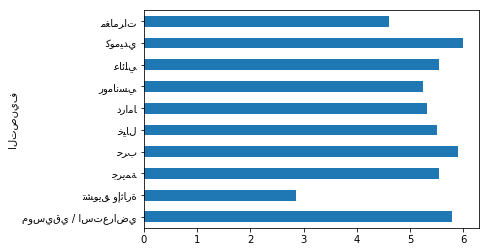

In [546]:
ratings_added_40s.groupby('التصنيف')['التقييم'].mean().plot.barh()


### What are the average ratings with respect to genres?

In [533]:
print('40s decade')
print(ratings_added_50s.groupby(['التصنيف'])['المدة'].mean())
print('-----------------')
print('50s decade')
print(ratings_added_60s.groupby(['التصنيف'])['المدة'].mean())
print('-----------------')
print('60s decade')
print(ratings_added_60s.groupby(['التصنيف'])['المدة'].mean())
print('70s decade')
print('-----------------')
print(ratings_added_70s.groupby(['التصنيف'])['المدة'].mean())

40s decade
التصنيف
تاريخي               106.500000
موسيقي / استعراضي    111.477419
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ         105.828571
ﺟﺮﻳﻤﺔ                113.900000
ﺣﺮﺏ                  103.500000
ﺣﺮﻛﺔ                 107.666667
ﺧﻴﺎﻝ                  95.000000
ﺧﻴﺎﻝ ﻋﻠﻤﻲ            104.333333
ﺩﺭاﻣﺎ                109.020833
ﺭﻋﺐ                  137.000000
ﺭﻭﻣﺎﻧﺴﻲ              108.729545
ﻋﺎﺋﻠﻲ                106.000000
ﻏﻤﻮﺽ                 101.000000
ﻛﻮﻣﻴﺪﻱ               107.620000
ﻣﻐﺎﻣﺮاﺕ              142.000000
Name: المدة, dtype: float64
-----------------
50s decade
التصنيف
تاريخي               118.500000
موسيقي / استعراضي    104.800000
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          99.761111
ﺟﺮﻳﻤﺔ                106.508333
ﺣﺮﻛﺔ                  96.428571
ﺧﻴﺎﻝ                 107.000000
ﺧﻴﺎﻝ ﻋﻠﻤﻲ            112.500000
ﺩﺭاﻣﺎ                105.535088
ﺭﻭﻣﺎﻧﺴﻲ              105.571739
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ           133.900000
ﻋﺎﺋﻠﻲ                 96.250000
ﻏﻤﻮﺽ                  95.000000
ﻗﺼﻴﺮ                  30.000000
ﻛﻮﻣﻴﺪﻱ              

### Who made movie music the most?

In [532]:
print(movies_df['موسيقى'].value_counts().head())

فؤاد الظاهري                   102
أندريا رايدر (أندريه رايدر)     37
علي إسماعيل                     31
عمر خورشيد                      31
جمال سلامة                      28
Name: موسيقى, dtype: int64
